# Modelling and Evaluating Cherry Leaf Images

## Objectives
* Answer Business Requirement 2:
    * The client is interested to know if a cherry leaf has powdery mildew or not.

## Inputs
* `data/cherry-leaves/train`
* `data/cherry-leaves/test`
* `data/cherry-leaves/validation`
* Image shape embeddings

## Outputs
* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file

## Objectives

* Build a CNN model to classify cherry leaf images as healthy or powdery_mildew.
* Train the model using the preprocessed data with augmentation.
* Evaluate the model's performance on unseen test data.

# Performance Results:
* Achieved >97% accuracy, meeting the client's requirement.

In [1]:
# Set Data Directory

## Import Libraries
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # This will force TensorFlow to use CPU

import os
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2025-02-14 19:19:21.457755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 19:19:21.466627: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 19:19:21.589195: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 19:19:21.681882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739560761.811603   46711 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739560761.84

# * Set Working Directory

In [2]:
current_dir = os.getcwd()
print(current_dir)

if current_dir!= '/workspaces/new2-cherry-leaves':
    os.chdir('/workspaces/new2-cherry-leaves')
    print("Changed working directory to /workspaces/new2-cherry-leaves")

work_dir = os.getcwd()
print(work_dir)

/workspaces/new2-cherry-leaves/jupyter_notebooks
Changed working directory to /workspaces/new2-cherry-leaves
/workspaces/new2-cherry-leaves


# * Set Input Directories
* Set train, validation, and test paths

In [3]:
data_dir = 'data/cherry-leaves'
test_path = os.path.join(data_dir, 'test')
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'validation')

# * Set Output Directory

In [4]:
version = 'v2'
output_path = f'outputs/{version}'

if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print('Output directory already exists.')

Output directory already exists.


* Set labels

In [5]:
labels = os.listdir(train_path)
print(f"Project Labels: {labels}")

Project Labels: ['powdery_mildew', 'healthy']


# * Load Image Shape

In [6]:
with open(f"outputs/v1/image_shape.pkl", 'rb') as f:
    image_shape = pickle.load(f)
print(image_shape)

(256, 256, 3)


# * Number of Images in Each Set

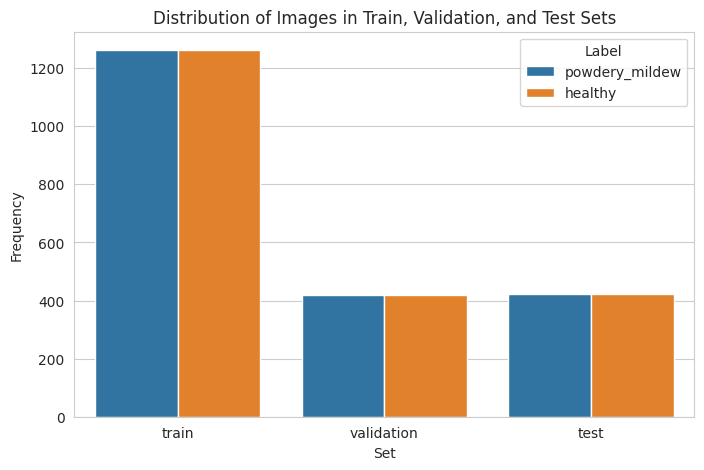

In [7]:
def count_images(path):
    """Counts the number of images in each subdirectory of a given path."""
    image_counts = {}
    for label in labels:
        # Use glob to find all files within the subdirectory
        image_counts[label] = len(glob.glob(os.path.join(path, label, '*'))) 
    return image_counts

train_counts = count_images(train_path)
val_counts = count_images(val_path)
test_counts = count_images(test_path)

# Initialize an empty list to store the data
data = []
for label in labels:
    # For each label, add the count of images in each set
    data.extend([
        {'Set': 'train', 'Label': label, 'Frequency': train_counts[label]},
        {'Set': 'validation', 'Label': label, 'Frequency': val_counts[label]},
        {'Set': 'test', 'Label': label, 'Frequency': test_counts[label]}
    ])

# Create a DataFrame from the collected data
df_freq = pd.DataFrame(data)

# Plot the distribution
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
# Create a bar plot to visualize the distribution of images across different sets and labels
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Distribution of Images in Train, Validation, and Test Sets")
# Save the plot to a file
plt.savefig(f'{output_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

# * Image data augmentation
* ImageDataGenerator

In [8]:
image_data_generator = ImageDataGenerator(
    width_shift_range=0.2, # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by 20% of the height
    shear_range=0.2, # Apply random shear transformations
    zoom_range=0.2, # Randomly zoom in and out on images by 20%
    horizontal_flip=True, # Randomly flip images horizontally
    vertical_flip=True, # Randomly flip images vertically
    fill_mode='nearest', # Use nearest neighbor interpolation to fill in gaps created by transformations
    rescale=1./255 # Rescale pixel values to the range
)

# * Create Data Generators

In [9]:
batch_size = 32

# Create a training data generator with augmentations
train_generator = image_data_generator.flow_from_directory(
    train_path,
    target_size=image_shape[:2], # Resize images to match the input shape of the model
    color_mode='rgb', # Load images in RGB format
    batch_size=batch_size,
    class_mode='binary', # Use binary class mode for two-class classification
    shuffle=True  # Shuffle the training data for better generalization
)

# Create a validation data generator with only rescaling
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False # Do not shuffle the validation data to maintain consistency
)

# Create a test data generator with only rescaling
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False # Do not shuffle the test data to maintain consistency
)

Found 2524 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


# * Visualize Augmented Images

In [10]:
def visualize_images(generator, num_images=3):
    """Displays a few images from the image data generator."""
    for _ in range(num_images):
        img, label = next(generator)
        for i in range(img.shape):  
            plt.imshow(img[i]) 
            plt.title(f"Label: {label[i]}")
            plt.axis('off')
            plt.show()

# * Save Class Indices

In [11]:
with open(f"{output_path}/class_indices.pkl", 'wb') as f:
    pickle.dump(train_generator.class_indices, f)

# * Model Creation
* Define the Model

In [12]:
def create_cnn_model(input_shape):
    """Creates a CNN model for image classification."""
    model = Sequential()

     # Using Input layer to define input shape
    model.add(Input(shape=input_shape))
    
    # Convolutional layers with ReLU activation
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2))) 

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn_model(image_shape)
model.summary() # Display the model architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 252, 252, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,876,033 (56.75 MB)

 Trainable params: 14,876,033 (56.75 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [13]:
# Define Early Stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(
    train_generator, # Training data generator
    epochs=25, # Number of training epochs
    steps_per_epoch=train_generator.samples // batch_size, # Steps per epoch
    validation_data=validation_generator, # Validation data generator
    validation_steps=validation_generator.samples // batch_size, # Validation steps
    callbacks=[early_stop], # Use Early Stopping to prevent overfitting
    verbose=1 # Display training progress
) 

/workspaces/new2-cherry-leaves/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.6091 - loss: 0.9128 - val_accuracy: 0.9928 - val_loss: 0.0917
Epoch 2/25
 1/78 ━━━━━━━━━━━━━━━━━━━━ 4:06 3s/step - accuracy: 0.9375 - loss: 0.2182

/workspaces/new2-cherry-leaves/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 0.9375 - loss: 0.2182 - val_accuracy: 0.9243 - val_loss: 0.1830
Epoch 3/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.9414 - loss: 0.1892 - val_accuracy: 0.9904 - val_loss: 0.0458
Epoch 4/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 1.0000 - loss: 0.0372 - val_accuracy: 0.9916 - val_loss: 0.0345
Epoch 5/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.9837 - loss: 0.0569 - val_accuracy: 0.9892 - val_loss: 0.0868
Epoch 6/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9868 - val_loss: 0.1104
Epoch 7/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.9445 - loss: 0.1559 - val_accuracy: 0.9952 - val_loss: 0.0260
Epoch 8/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - accuracy: 0.8438 - loss: 0.3169 - val_accuracy: 0.9952 - val_loss: 0.0265
Epoch 9/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step - accuracy: 0.9818 - loss: 0.0638 - val_accuracy: 0.9916 - val_

# * Save the Model

In [14]:
model.save(f'{output_path}/cherry_leaves_model.keras')

# Model Performance
* Learning Curves

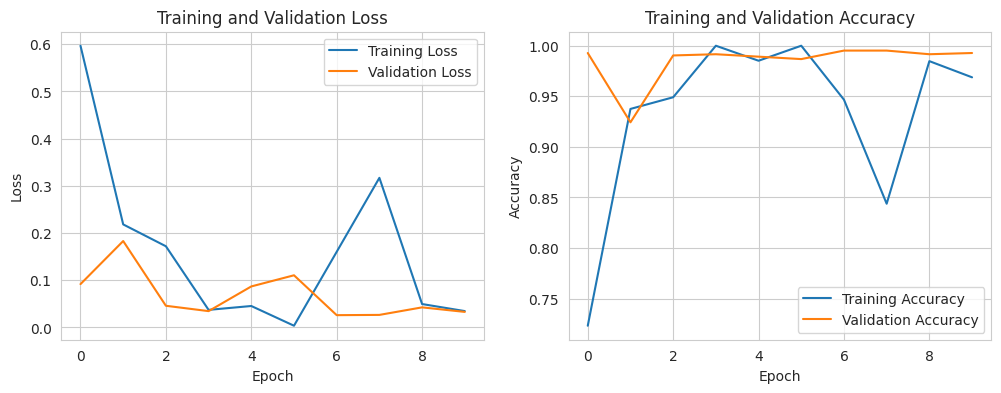

In [15]:
def plot_learning_curves(history):
    """Plots the training and validation loss and accuracy curves."""
    plt.figure(figsize=(12, 4))

    # Plot the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Save and display the plot
    plt.savefig(f'{output_path}/learning_curves.png', bbox_inches='tight', dpi=150)
    plt.show()

plot_learning_curves(history)

# * Model Evaluation
* Evaluate on Test Set

In [16]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 873ms/step - accuracy: 0.9970 - loss: 0.0149
Test Accuracy: 99.41%


# * Classification Report and Confusion Matrix

27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 853ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       422
           1       1.00      0.99      0.99       422

    accuracy                           0.99       844
   macro avg       0.99      0.99      0.99       844
weighted avg       0.99      0.99      0.99       844



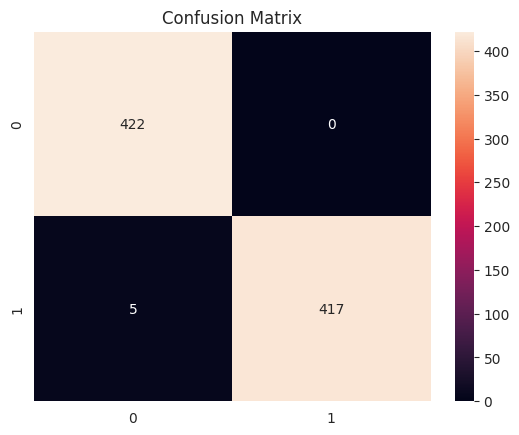

In [17]:
# Generate predictions on the test set
y_pred = model.predict(test_generator)

# Convert prediction probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int) 
y_true = test_generator.classes # Get the true class labels from the generator

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Create and display the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# * Save Evaluation Results

In [18]:
with open(f'{output_path}/evaluation_results.pkl', 'wb') as f:
    pickle.dump({'test_loss': test_loss, 'test_acc': test_acc}, f)

# * Prediction on New Data
* Load and Preprocess Image

In [19]:
import numpy as np
from keras.preprocessing import image

def predict_on_new_image(image_path):
    img = image.load_img(image_path, target_size=image_shape, color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)

    # Get the predicted class:
    predicted_class_index = np.argmax(prediction)  
    target_map = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = target_map[predicted_class_index]

    print(f"Predicted Probability: {prediction[0][predicted_class_index]:.4f}") 
    print(f"Predicted Class: {predicted_class}")

# Example usage (using the file path):
predict_on_new_image('/workspaces/new2-cherry-leaves/data/cherry-leaves/test/healthy/0b2ed0b4-a6e1-4fb3-82dc-47f903f3d0a9___JR_HL 9603.JPG')

FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/new2-cherry-leaves/data/cherry-leaves/test/healthy/0b2ed0b4-a6e1-4fb3-82dc-47f903f3d0a9___JR_HL 9603.JPG'